In [56]:
# Librerías de datos y visualización
import geopandas as gpd
import pandas as pd
import numpy as np
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cdist

In [2]:
# Cargar los datos de secciones electorales
secciones = gpd.read_file('datos/secciones-electorales-pba.geojson')
secciones

,fid,fna,gna,nam,sag,seccion,geometry
0,1.0,Partido de Vicente López,Partido,Vicente López,IDEBA,I,"MULTIPOLYGON (((-58.523 -34.5976, -58.5231 -34..."
1,2.0,Partido de Rojas,Partido,Rojas,IDEBA,II,"MULTIPOLYGON (((-59.1967 -34.3737, -59.1967 -3..."
2,3.0,Partido de Magdalena,Partido,Magdalena,IDEBA,III,"MULTIPOLYGON (((-57.2767 -35.2257, -57.2766 -3..."
3,4.0,Partido de General Pinto,Partido,General Pinto,IDEBA,IV,"MULTIPOLYGON (((-61.2698 -36.0711, -61.2699 -3..."
4,5.0,Partido de General Lavalle,Partido,General Lavalle,IDEBA,V,"MULTIPOLYGON (((-59.3328 -38.7367, -59.3328 -3..."
5,6.0,Partido de Coronel Suárez,Partido,Coronel Suárez,IDEBA,VI,"MULTIPOLYGON (((-62.2489 -39.817, -62.2491 -39..."
6,7.0,Partido de Saladillo,Partido,Saladillo,IDEBA,VII,"MULTIPOLYGON (((-59.4882 -36.2271, -59.4881 -3..."
7,8.0,Partido de La Plata,Partido,La Plata,IDEBA,VIII,"MULTIPOLYGON (((-57.8082 -34.9621, -57.8038 -3..."


In [3]:
# Cantidad de bancas por sección que no se renuevan
senado_no_elegido = {"Capital": {"UxP":2, "PRO": 1},
                     "Segunda": {"UxP":2, "PRO": 2, "Unión renovación y fe": 1},
                     "Tercera": {"UxP":5, "PRO": 1, "LLA": 3},
                     "Sexta": {"UxP":2, "PRO": 1, "UCR": 1, "Unión renovación y fe": 2}
                     }

diputados_no_elegidos ={"Primera": {"UxP":7, "PRO": 2, "LLA": 4, "Unión renovación y fe": 2, "UNIÓN Y LIBERTAD": 1},
                        "Cuarta": {"UxP":5, "PRO": 2, "Coalición cívica": 1, "Unión renovación y fe": 1, "UCR + Cambio Federal": 2, "UNIÓN Y LIBERTAD": 2},
                        "Quinta": {"UxP":4, "UCR + Cambio Federal": 1, "Acuerdo cívico - UCR + Gen": 1, "Coalición cívica": 1, "LLA": 3, "UNIÓN Y LIBERTAD": 1},
                        "Séptima": {"UxP":2, "PRO": 1, "LLA": 1, "UCR + Cambio Federal": 1, "UNIÓN Y LIBERTAD": 1},
}

In [4]:
# Cantidad de bancas por sección a elegir
secciones_diputados = {
    "Capital": 6,
    "Segunda": 11,
    "Tercera": 18,
    "Sexta": 11    
}

secciones_senadores = {
    "Primera": 8,
    "Cuarta": 7,
    "Quinta": 5,
    "Séptima": 3
}

# Padrón real por sección (actualizado a 2025)
padron_real = {
    "Capital": 576_691,
    "Primera": 4_732_831,
    "Segunda": 649_465,
    "Tercera": 4_637_863,
    "Cuarta": 540_354,
    "Quinta": 1_290_948, 
    "Sexta": 652_077, 
    "Séptima": 281_130
}

listas_politicas = [
    "Alianza La Libertad Avanza",  # PRO + LLA
    "Fuerza Patria",               # UxP
    "Somos Buenos Aires",          # UCR + PJ no K
    "Avanza Libertad",             # Libertarios - BLUE
    "FIT-U"                        # Izquierda
]

In [5]:
def repartir_bancas(df):
    out = []

    for seccion, grupo in df.groupby("seccion"):
        total_votos = grupo["votos"].sum()
        cargos      = grupo["cargos"].iloc[0]
        cuociente   = max(1, total_votos // cargos)        # ← asegura ≥1

        grupo = grupo.copy()
        grupo["enteros"] = grupo["votos"] // cuociente
        grupo["residuo"] = grupo["votos"] %  cuociente
        grupo["bancas"]  = grupo["enteros"]

        # ── Restos solo entre listas con ≥1 cuociente
        faltan = cargos - grupo["bancas"].sum()
        if faltan:
            elig = grupo[grupo["enteros"] > 0]
            if not elig.empty:
                idx = (elig.sort_values(["residuo", "votos"],
                                        ascending=False)
                             .head(faltan).index)
                grupo.loc[idx, "bancas"] += 1

        # ── Art. 110: nadie alcanzó cuociente
        if grupo["bancas"].sum() == 0:
            q = cuociente
            while grupo["bancas"].sum() == 0:
                q = max(1, q // 2)
                grupo["enteros"] = grupo["votos"] // q
                grupo["residuo"] = grupo["votos"] %  q
                grupo["bancas"]  = grupo["enteros"]

                faltan = cargos - grupo["bancas"].sum()
                if faltan:
                    elig = grupo[grupo["enteros"] > 0]
                    if not elig.empty:
                        idx = (elig.sort_values(["residuo", "votos"],
                                                ascending=False)
                                       .head(faltan).index)
                        grupo.loc[idx, "bancas"] += 1

        # ── Paso 5: completar con la lista más votada
        faltan = cargos - grupo["bancas"].sum()
        if faltan:
            top = grupo["votos"].idxmax()
            grupo.loc[top, "bancas"] += faltan

        out.append(grupo[["seccion", "lista", "bancas"]])

    return pd.concat(out, ignore_index=True)


In [59]:
# Parámetros de simulación
participacion = 0.60
votos_validos_pct = 0.90
N = 1000
np.random.seed(123)

def simular_eleccion(dirichlet_pesos, phi=None):
    """Devuelve df_bancas_diputados y df_bancas_senadores para 1 corrida."""
    # 1) proporción provincial (si usás modelo jerárquico)
    if phi is not None:
        P_prov = np.random.dirichlet(dirichlet_pesos)

    # ------- helpers ----------
    def simular_y_repartir(secciones_camara):
        filas = []
        for sec, cargos in secciones_camara.items():
            pad = padron_real[sec]
            votos_validos = int(pad * participacion * votos_validos_pct)

            if phi is None:  # Dirichlet independiente
                prop = np.random.dirichlet(dirichlet_pesos)
            else:            # Jerárquico
                prop = np.random.dirichlet(P_prov * phi)

            votos = (prop * votos_validos).astype(int)
            for lista, v in zip(listas_politicas, votos):
                filas.append({"seccion": sec, "lista": lista,
                              "votos": v, "cargos": cargos})
        df = pd.DataFrame(filas)
        return repartir_bancas(df)

    dip = simular_y_repartir(secciones_diputados)
    sen = simular_y_repartir(secciones_senadores)
    return dip, sen

# ---------- MONTE CARLO -----------

# Input: lista de porcentajes que suman 100
creencias = [36, 35, 15, 10, 4]
alpha_scale = 25
pesos_dirichlet = np.array(creencias) * alpha_scale / 100 #alphas

dip_acum, sen_acum = [], []
for _ in range(N):
    d,s = simular_eleccion(pesos_dirichlet, phi=50)
    dip_acum.append(d.groupby("lista").bancas.sum())
    sen_acum.append(s.groupby("lista").bancas.sum())

dip_mc = pd.DataFrame(dip_acum).reindex(columns=listas_politicas).fillna(0)
sen_mc = pd.DataFrame(sen_acum).reindex(columns=listas_politicas).fillna(0)

def medoid(df):
    df = df.fillna(0)                         # ← limpia NaN
    if df.empty:
        raise ValueError("DataFrame vacío")
    D = cdist(df.values, df.values, metric="cityblock")
    idx = np.nanargmin(D.sum(axis=1))        # ← ignora NaN en cálculo
    return df.iloc[idx].astype(int)          # ← vector entero

def resumen(df):
    return pd.DataFrame({
        "media": df.mean(),
        "p5":    df.quantile(0.05),
        "p95":   df.quantile(0.95),
        "Bancas": medoid(df).astype(int)
    }).round(2)   

tbl_dip = resumen(dip_mc)
tbl_sen = resumen(sen_mc)

print("\nBANCAS EN DIPUTADOS ({} simulaciones)".format(N))
print(tbl_dip)
print("\nBANCAS EN SENADO ({} simulaciones)".format(N))
print(tbl_sen)


BANCAS EN DIPUTADOS (1000 simulaciones)
                            media   p5   p95  Bancas
lista                                               
Alianza La Libertad Avanza  17.48  9.0  26.0      17
Fuerza Patria               17.31  9.0  26.0      18
Somos Buenos Aires           6.63  0.0  14.0       7
Avanza Libertad              3.61  0.0  10.0       4
FIT-U                        0.97  0.0   5.0       0

BANCAS EN SENADO (1000 simulaciones)
                            media   p5   p95  Bancas
lista                                               
Alianza La Libertad Avanza   9.68  4.0  15.0      11
Fuerza Patria                9.49  4.0  15.0      10
Somos Buenos Aires           2.54  0.0   8.0       2
Avanza Libertad              1.08  0.0   5.0       0
FIT-U                        0.21  0.0   2.0       0


lista,Alianza La Libertad Avanza,Fuerza Patria,Somos Buenos Aires,Avanza Libertad,FIT-U
bancas,9,24,1,10,2
bancas,17,25,4,0,0
bancas,15,22,9,0,0
bancas,17,26,2,1,0
bancas,15,14,13,4,0
...,...,...,...,...,...
bancas,13,19,14,0,0
bancas,25,11,4,6,0
bancas,19,15,9,3,0
bancas,14,18,8,6,0


In [64]:
dip_medoid = medoid(dip_mc)
sen_medoid = medoid(sen_mc)

def sumar_no_renovados(medoid_vec, no_elegido_dict):
    # medoid_vec es una Serie indexada por partidos
    total = medoid_vec.copy()
    for seccion, dic in no_elegido_dict.items():
        for partido, n in dic.items():
            total[partido] = total.get(partido, 0) + n
    return total.astype(int)

diputados_2025 = sumar_no_renovados(dip_medoid, diputados_no_elegidos)
senado_2025    = sumar_no_renovados(sen_medoid, senado_no_elegido)

print("\nCámara de Diputados (total 92):")
print(diputados_2025.sort_values(ascending=False).to_string())
print("\nSenado provincial (total 46):")
print(senado_2025.sort_values(ascending=False).to_string())



Cámara de Diputados (total 92):
lista
Fuerza Patria                 18
UxP                           18
Alianza La Libertad Avanza    17
LLA                            8
Somos Buenos Aires             7
PRO                            5
UNIÓN Y LIBERTAD               5
UCR + Cambio Federal           4
Avanza Libertad                4
Unión renovación y fe          3
Coalición cívica               2
Acuerdo cívico - UCR + Gen     1
FIT-U                          0

Senado provincial (total 46):
lista
Alianza La Libertad Avanza    11
UxP                           11
Fuerza Patria                 10
PRO                            5
Unión renovación y fe          3
LLA                            3
Somos Buenos Aires             2
UCR                            1
FIT-U                          0
Avanza Libertad                0


In [13]:
! pip install poli-sci-kit

     ---------------------------------------- 0.0/81.3 kB ? eta -:--:--
     ---------------------------------------- 0.0/81.3 kB ? eta -:--:--
     ----- ---------------------------------- 10.2/81.3 kB ? eta -:--:--
     ----- ---------------------------------- 10.2/81.3 kB ? eta -:--:--
     ------------------- ------------------ 41.0/81.3 kB 281.8 kB/s eta 0:00:01
     ------------------- ------------------ 41.0/81.3 kB 281.8 kB/s eta 0:00:01
     --------------------------------- ---- 71.7/81.3 kB 280.5 kB/s eta 0:00:01
     -------------------------------------- 81.3/81.3 kB 268.0 kB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached cffi-1.17.1-cp311-cp311-win_amd64.whl.metadat


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


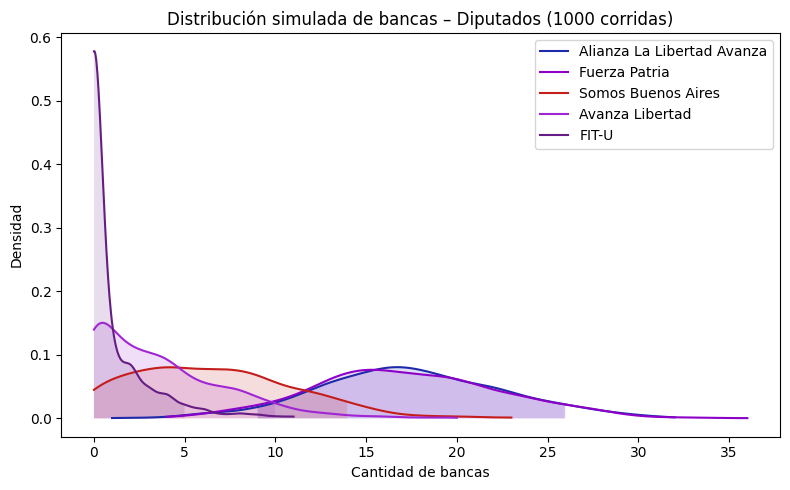

In [65]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde   # viene con SciPy

# dip_mc es el DataFrame con las 1000 simulaciones (filas) y partidos (columnas)

plt.figure(figsize=(8,5))

for partido in dip_mc.columns:
    datos = dip_mc[partido].values
    # --- curva KDE ---
    kde  = gaussian_kde(datos, bw_method='scott')   # suavizado automático
    xs   = np.linspace(datos.min(), datos.max(), 400)
    dens = kde(xs)
    plt.plot(xs, dens, label=partido)               # línea suave
    
    # --- intervalo p5–p95 ---
    p5, p95 = np.percentile(datos, [5, 95])
    mask = (xs >= p5) & (xs <= p95)
    plt.fill_between(xs[mask], dens[mask], alpha=0.15)   # misma tonalidad, +transparencia

plt.title("Distribución simulada de bancas – Diputados (1000 corridas)")
plt.xlabel("Cantidad de bancas")
plt.ylabel("Densidad")
plt.legend()
plt.tight_layout()
plt.show()


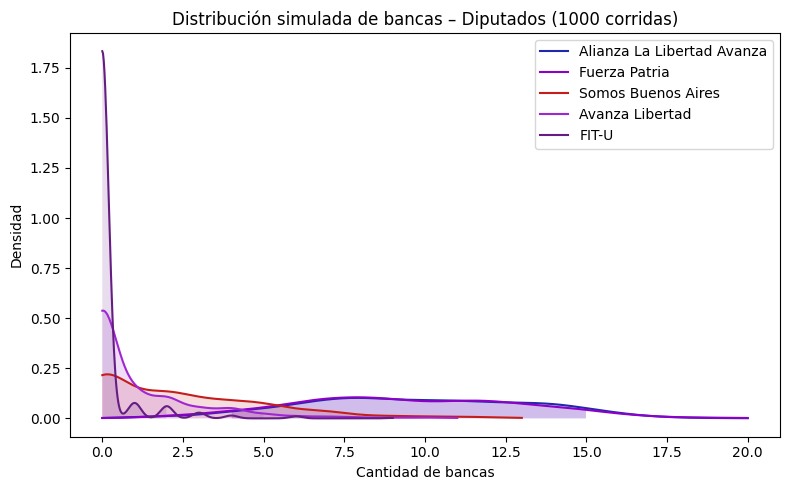

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde   # viene con SciPy

# dip_mc es el DataFrame con las 1000 simulaciones (filas) y partidos (columnas)

plt.figure(figsize=(8,5))

for partido in sen_mc.columns:
    datos = sen_mc[partido].values
    # --- curva KDE ---
    kde  = gaussian_kde(datos, bw_method='scott')   # suavizado automático
    xs   = np.linspace(datos.min(), datos.max(), 400)
    dens = kde(xs)
    plt.plot(xs, dens, label=partido)               # línea suave
    
    # --- intervalo p5–p95 ---
    p5, p95 = np.percentile(datos, [5, 95])
    mask = (xs >= p5) & (xs <= p95)
    plt.fill_between(xs[mask], dens[mask], alpha=0.15)   # misma tonalidad, +transparencia

plt.title("Distribución simulada de bancas – Diputados (1000 corridas)")
plt.xlabel("Cantidad de bancas")
plt.ylabel("Densidad")
plt.legend()
plt.tight_layout()
plt.show()


In [128]:
# DIPUTADOS
bancas_diputados = (
    df_bancas_diputados.groupby("lista")["bancas"]
    .sum()
    .sort_values(ascending=False)
    .reset_index()
    .rename(columns={"lista": "Partido", "bancas": "Bancas en Diputados"})
)

# SENADORES
bancas_senadores = (
    df_bancas_senadores.groupby("lista")["bancas"]
    .sum()
    .sort_values(ascending=False)
    .reset_index()
    .rename(columns={"lista": "Partido", "bancas": "Bancas en Senado"})
)

# Mostrar tablas
print("\n Bancas en Diputados:")
print(bancas_diputados.to_string(index=False))

print("\n Bancas en Senado:")
print(bancas_senadores.to_string(index=False))


 Bancas en Diputados:
                   Partido  Bancas en Diputados
             Fuerza Patria                   20
Alianza La Libertad Avanza                   17
        Somos Buenos Aires                    6
           Avanza Libertad                    2
                     FIT-U                    0

 Bancas en Senado:
                   Partido  Bancas en Senado
Alianza La Libertad Avanza                 9
             Fuerza Patria                 9
        Somos Buenos Aires                 2
                     FIT-U                 0
           Avanza Libertad                 0


In [129]:
ganadores_dip = (
    df_bancas_diputados.sort_values(["seccion", "bancas"], ascending=[True, False])
    .drop_duplicates("seccion")[["seccion", "lista"]]
    .rename(columns={"lista": "ganador_diputados"})
)

ganadores_sen = (
    df_bancas_senadores.sort_values(["seccion", "bancas"], ascending=[True, False])
    .drop_duplicates("seccion")[["seccion", "lista"]]
    .rename(columns={"lista": "ganador_senadores"})
)

In [130]:
# Mapeo de números romanos a nombres de sección
romanos_a_nombre = {
    "I": "Primera",
    "II": "Segunda",
    "III": "Tercera",
    "IV": "Cuarta",
    "V": "Quinta",
    "VI": "Sexta",
    "VII": "Séptima",
    "VIII": "Capital"
}

# Función de normalización
def normalizar(texto):
    return str(texto).strip().title()

# Aplicar mapeo y normalización al GeoDataFrame
secciones["seccion"] = secciones["seccion"].map(romanos_a_nombre)
secciones["seccion"] = secciones["seccion"].apply(normalizar)

# Normalizar también los DataFrames de bancas
df_bancas_diputados["seccion"] = df_bancas_diputados["seccion"].apply(normalizar)
df_bancas_senadores["seccion"] = df_bancas_senadores["seccion"].apply(normalizar)

# Crear nueva copia para trabajar visualización
secciones_resultado = secciones.copy()

# Merge con ganadores de cada cámara
secciones_resultado = secciones_resultado.merge(ganadores_dip, on="seccion", how="left")
secciones_resultado = secciones_resultado.merge(ganadores_sen, on="seccion", how="left")


In [131]:
print("Secciones no emparejadas en Diputados:")
print(set(df_bancas_diputados["seccion"]) - set(secciones["seccion"]))

print("Secciones no emparejadas en Senadores:")
print(set(df_bancas_senadores["seccion"]) - set(secciones["seccion"]))


Secciones no emparejadas en Diputados:
set()
Secciones no emparejadas en Senadores:
set()


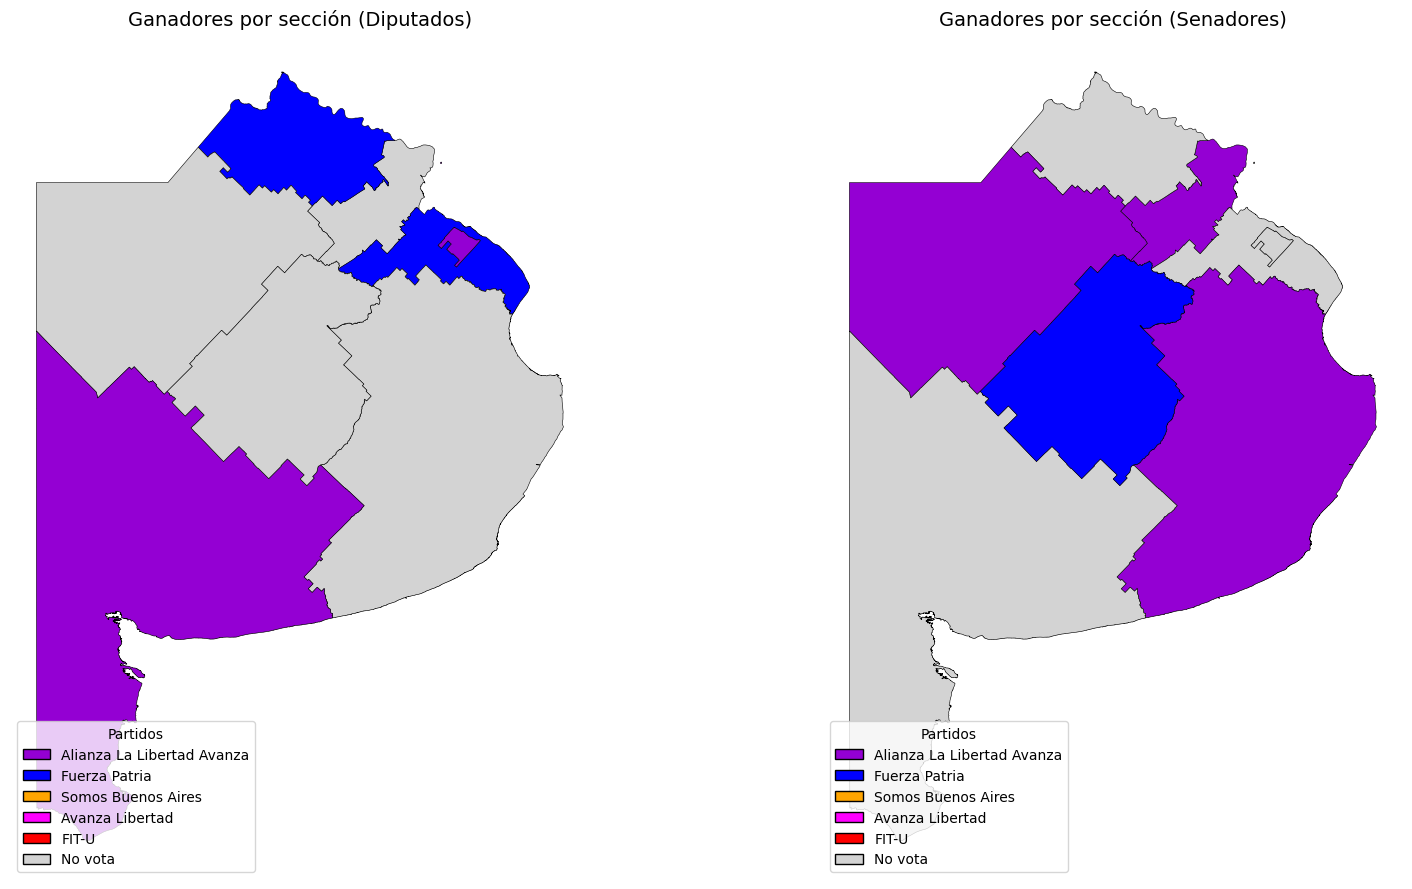

In [132]:
# Diccionario de colores
colores = {
    "Alianza La Libertad Avanza": "darkviolet",
    "Fuerza Patria": "blue",
    "Somos Buenos Aires": "orange",
    "Avanza Libertad": "magenta",
    "FIT-U": "red"
}

# Colores asignados por sección, con gris para NaN
color_diputados = secciones_resultado["ganador_diputados"].map(colores).fillna("lightgray")
color_senadores = secciones_resultado["ganador_senadores"].map(colores).fillna("lightgray")

# Leyenda común
legend_elements = [
    Patch(facecolor=colores[lista], edgecolor='black', label=lista)
    for lista in listas_politicas
]
legend_elements.append(Patch(facecolor="lightgray", edgecolor='black', label="No vota"))

# Crear figuras
fig, axs = plt.subplots(1, 2, figsize=(18, 9))

# Diputados
secciones_resultado.plot(
    color=color_diputados,
    ax=axs[0],
    edgecolor="black",
    linewidth=0.4
)
axs[0].set_title("Ganadores por sección (Diputados)", fontsize=14)
axs[0].axis("off")
axs[0].legend(handles=legend_elements, loc='lower left', title="Partidos")

# Senadores
secciones_resultado.plot(
    color=color_senadores,
    ax=axs[1],
    edgecolor="black",
    linewidth=0.4
)
axs[1].set_title("Ganadores por sección (Senadores)", fontsize=14)
axs[1].axis("off")
axs[1].legend(handles=legend_elements, loc='lower left', title="Partidos")

plt.tight_layout()
plt.show()


In [133]:
secciones_resultado[["seccion", "ganador_diputados", "ganador_senadores"]]


,seccion,ganador_diputados,ganador_senadores
0,Primera,NaN,Alianza La Libertad Avanza
1,Segunda,Fuerza Patria,NaN
2,Tercera,Fuerza Patria,NaN
3,Cuarta,NaN,Alianza La Libertad Avanza
4,Quinta,NaN,Alianza La Libertad Avanza
5,Sexta,Alianza La Libertad Avanza,NaN
6,Séptima,NaN,Fuerza Patria
7,Capital,Alianza La Libertad Avanza,NaN


In [12]:
# 1.  Porcentajes fijos por alianza
creencias = {
    "Alianza La Libertad Avanza": 36,
    "Fuerza Patria": 35,
    "Somos Buenos Aires": 15,
    "Avanza Libertad": 10,
    "FIT-U": 4
}

# 2.  Votos válidos por sección (participación fija)
participacion = 0.60
votos_validos_pct = 0.90

filas = []
for seccion, cargos in secciones_diputados.items():          # idem para senadores
    pad = padron_real[seccion]
    total_validos = int(pad * participacion * votos_validos_pct)
    for alianza, pct in creencias.items():
        votos = int(total_validos * pct / 100)
        filas.append({"seccion": seccion,
                      "lista": alianza,
                      "votos": votos,
                      "cargos": cargos})
df_dip_det = pd.DataFrame(filas)

# 3.  Reparto con tu función repartir_bancas() (ya sin aleatoriedad)
dip_bancas_det = repartir_bancas(df_dip_det)

print("\nReparto determinista – Diputados (participación 60 %)")
print(dip_bancas_det.pivot(index="seccion", columns="lista", values="bancas").fillna(0).astype(int))



Reparto determinista – Diputados (participación 60 %)
lista    Alianza La Libertad Avanza  Avanza Libertad  FIT-U  Fuerza Patria  \
seccion                                                                      
Capital                           3                0      0              3   
Segunda                           4                1      0              4   
Sexta                             4                1      0              4   
Tercera                           7                2      0              6   

lista    Somos Buenos Aires  
seccion                      
Capital                   0  
Segunda                   2  
Sexta                     2  
Tercera                   3  


In [14]:
filas2 = []
for seccion, cargos in secciones_senadores.items():          # idem para senadores
    pad = padron_real[seccion]
    total_validos = int(pad * participacion * votos_validos_pct)
    for alianza, pct in creencias.items():
        votos = int(total_validos * pct / 100)
        filas2.append({"seccion": seccion,
                      "lista": alianza,
                      "votos": votos,
                      "cargos": cargos})
df_sen_det = pd.DataFrame(filas2)

# 3.  Reparto con tu función repartir_bancas() (ya sin aleatoriedad)
sen_bancas_det = repartir_bancas(df_sen_det)

print("\nReparto determinista – Diputados (participación 60 %)")
print(sen_bancas_det.pivot(index="seccion", columns="lista", values="bancas").fillna(0).astype(int))


Reparto determinista – Diputados (participación 60 %)
lista    Alianza La Libertad Avanza  Avanza Libertad  FIT-U  Fuerza Patria  \
seccion                                                                      
Cuarta                            3                0      0              3   
Primera                           3                0      0              3   
Quinta                            3                0      0              2   
Séptima                           2                0      0              1   

lista    Somos Buenos Aires  
seccion                      
Cuarta                    1  
Primera                   2  
Quinta                    0  
Séptima                   0  


In [27]:
alianzas_2023_a_2025 = {
    "PRO": "Alianza La Libertad Avanza",
    "LLA": "Alianza La Libertad Avanza",
    "UxP": "Fuerza Patria",
    "UCR": "Somos Buenos Aires",
    "Cambio Federal": "Somos Buenos Aires",
    "Coalición cívica": "Somos Buenos Aires",
    "UCR + Cambio Federal": "Somos Buenos Aires",
    "Unión renovación y fe": "Unión renovación y fe",
    "UNIÓN Y LIBERTAD": "UNIÓN Y LIBERTAD",
    "FIT-U": "FIT-U",
    "Acuerdo cívico - UCR + Gen": "Somos Buenos Aires"
}


In [28]:
def mapear_a_alianzas(diccionario, secciones_dict):
    nuevo = {}
    for seccion, partidos in secciones_dict.items():
        nuevo[seccion] = {}
        for partido, bancas in partidos.items():
            alianza = diccionario.get(partido, partido)
            nuevo[seccion][alianza] = nuevo[seccion].get(alianza, 0) + bancas
    return nuevo

senado_no_elegido_alianzas = mapear_a_alianzas(alianzas_2023_a_2025, senado_no_elegido)
diputados_no_elegidos_alianzas = mapear_a_alianzas(alianzas_2023_a_2025, diputados_no_elegidos)


In [29]:
# Convertimos el dict anidado en DataFrame
df_dip_actual = (
    pd.DataFrame(diputados_no_elegidos_alianzas)
      .fillna(0)
      .astype(int)
      .T  # secciones como filas
)

# Sumamos total de bancas actuales por alianza
bancas_no_renuevan = df_dip_actual.sum().reindex(listas_politicas, fill_value=0)


In [30]:
# Pivot de las bancas deterministas por sección y alianza
df_dip_nuevos = (
    dip_bancas_det
    .pivot_table(index="seccion", columns="lista", values="bancas", aggfunc="sum")
    .fillna(0)
    .astype(int)
)

# Sumamos las nuevas bancas por alianza
bancas_nuevas = df_dip_nuevos.sum().reindex(listas_politicas, fill_value=0)


In [43]:
# Sumar bancas actuales (no renovadas) + simuladas
diputados_2025 = (
    pd.Series(diputados_no_elegidos_alianzas)
    .apply(pd.Series)
    .fillna(0).sum()
    .add(dip_bancas_det.groupby("lista").bancas.sum(), fill_value=0)
    .astype(int)
    .loc[lambda x: x > 0]               # ← filtra los ceros
    .sort_values(ascending=False)       # ← ordena de mayor a menor
)

print(diputados_2025)


Fuerza Patria                 35
Alianza La Libertad Avanza    31
Somos Buenos Aires            14
UNIÓN Y LIBERTAD               5
Avanza Libertad                4
Unión renovación y fe          3
dtype: int64


In [46]:
senadores_2025 = (
    pd.Series(senado_no_elegido_alianzas)
    .apply(pd.Series)
    .fillna(0).sum()
    .add(sen_bancas_det.groupby("lista").bancas.sum(), fill_value=0)
    .astype(int)
    .loc[lambda x: x > 0]
    .sort_values(ascending=False)
)
print(senadores_2025)

Fuerza Patria                 20
Alianza La Libertad Avanza    19
Somos Buenos Aires             4
Unión renovación y fe          3
dtype: int64


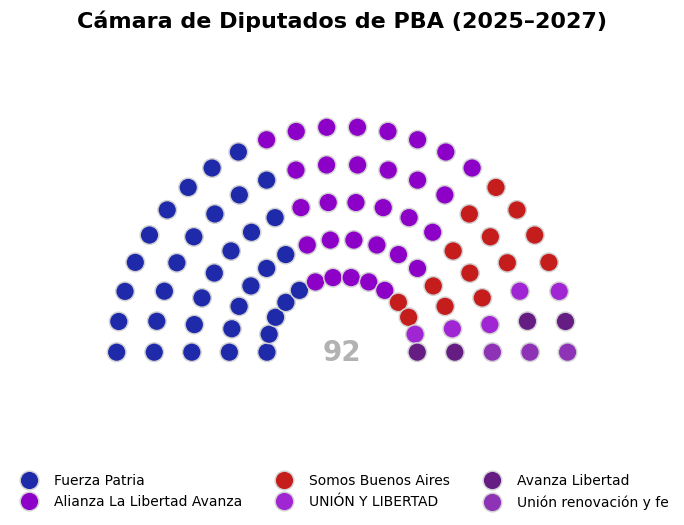

In [55]:
import poli_sci_kit.plot as pk

# Listas de etiquetas y colores asociadas a los datos ordenados
dip_final  = diputados_2025.tolist()
etiquetas  = diputados_2025.index.tolist()

colores = {
    "Alianza La Libertad Avanza": "#9400D3",  
    "Avanza Libertad": "#6A1E8AE2",
    "UNIÓN Y LIBERTAD": "#A62ED9E3",                 
    "Unión renovación y fe": "#9536BEB3",  
    "Fuerza Patria": "#202CB3DD",              
    "Somos Buenos Aires": "#CF1D1D"    
}
colores_usados = [colores[nombre] for nombre in diputados_2025.index]

# colores    = ["#9370DB", "#B22222", "#FFA500", "#FFD700", "#6A5ACD", "#"][:len(etiquetas)]

# Graficar
ax = pk.parliament(allocations=diputados_2025.tolist(),
                   labels=diputados_2025.index.tolist(),
                   colors=colores_usados,
                   style="semicircle",
                   num_rows = 5,
                   marker_size = 180,
                   legend=True)

ax.set_title("Cámara de Diputados de PBA (2025–2027)",
             fontsize=16, fontweight='bold', pad=20)

total_bancas = diputados_2025.sum()

ax.text(0, 0, str(total_bancas),
        ha='center', va='center',
        fontsize=20, fontweight='bold',
        color='gray', alpha=0.6)


ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          ncol=3, frameon=False)



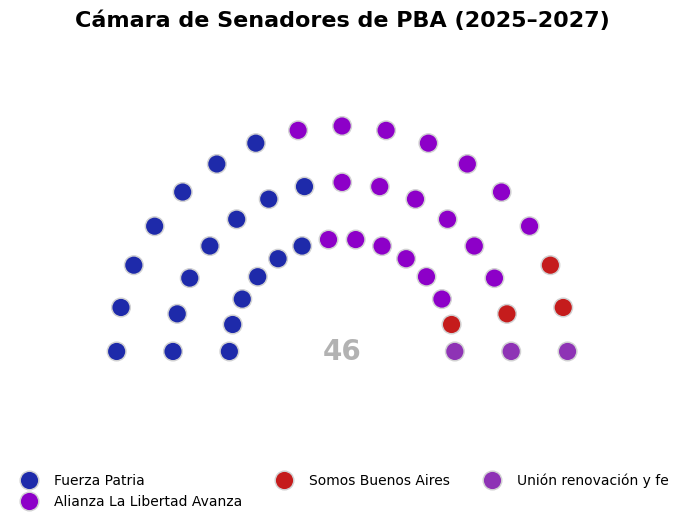

In [52]:
import poli_sci_kit.plot as pk

# Listas de etiquetas y colores asociadas a los datos ordenados
dip_final  = senadores_2025.tolist()
etiquetas  = senadores_2025.index.tolist()

colores = {
    "Alianza La Libertad Avanza": "#9400D3",                
    "Unión renovación y fe": "#9536BEB3",  
    "Fuerza Patria": "#202CB3DD",              
    "Somos Buenos Aires": "#CF1D1D"    
}
colores_usados = [colores[nombre] for nombre in senadores_2025.index]

# colores    = ["#9370DB", "#B22222", "#FFA500", "#FFD700", "#6A5ACD", "#"][:len(etiquetas)]

# Graficar
ax = pk.parliament(allocations=senadores_2025.tolist(),
                   labels=senadores_2025.index.tolist(),
                   colors=colores_usados,
                   style="semicircle",
                   num_rows = 3,
                   marker_size = 180,
                   legend=True)

ax.set_title("Cámara de Senadores de PBA (2025–2027)",
             fontsize=16, fontweight='bold', pad=20)

total_bancas = senadores_2025.sum()

ax.text(0, 0, str(total_bancas),
        ha='center', va='center',
        fontsize=20, fontweight='bold',
        color='gray', alpha=0.6)


ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          ncol=3, frameon=False)
